In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [3]:
from scipy.fftpack import fft

# t_n = duration
# N = number of pressure
# T = t_n / N
# f_s = 1/T

def get_fft_values(y_values, duration, N):
    T = duration/N
    f_s = 1/T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    
    return f_values, fft_values


In [4]:
from scipy.signal import welch

def get_psd_values(y_values, duration, N):
    T = duration/N
    f_s = 1/T
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values


In [5]:
#only keep pressure data bwtween th first peak and the last peak
def preprocess(x):

    peaks, _ = find_peaks(x, height=0)
    peak_avg = np.mean(x)
    temp_peak = []
    first_index = 0
    last_index = -1
    for row in x[peaks]:
        if row > peak_avg:
            temp_peak.append(row)
    first_peak = temp_peak[0]
    last_peak = temp_peak[-1]
    for i in range(len(x)):
        if x[i] == first_peak:
            first_index = i
            break
            
    for j in reversed(range(len(x))):
        if x[j] == last_peak:
            last_index = j
            break
            
    x = x[first_index:last_index]
    
    return x, first_index, last_index

In [6]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, duration, N):
    T = duration/N
    f_s = 1/T
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

In [7]:
import glob
import os

files_PaHaW = []
fileDir = 'PaHaW_csv'
for root, dirs, files in os.walk(fileDir, topdown=False):
    for name in dirs:
        files_PaHaW.append(os.path.join(root, name))
        
charts = []

for i in files_PaHaW[2:]:
    charts.append(os.path.join(i, ''.join([j for j in os.listdir(i) if '__1_1.csv' in j])))
    

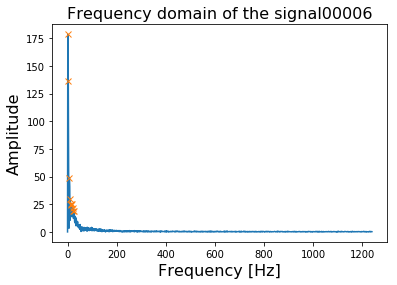

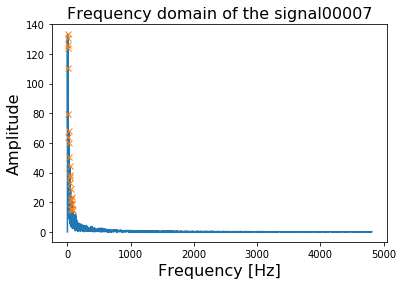

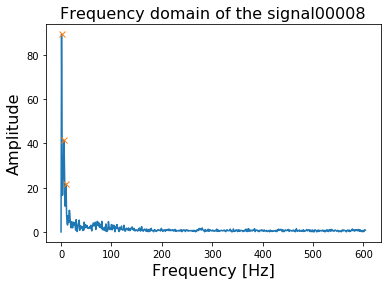

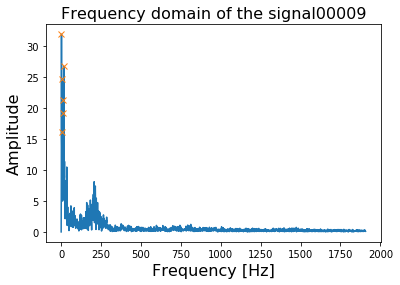

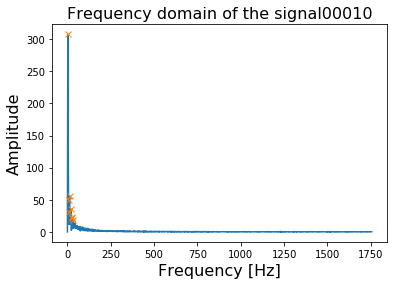

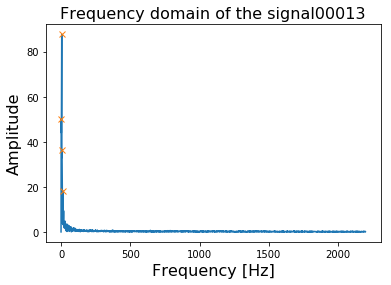

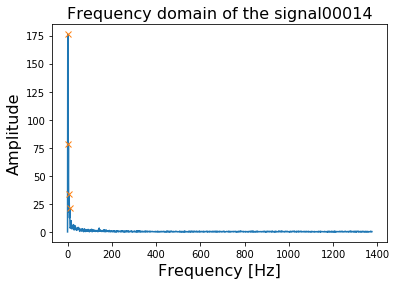

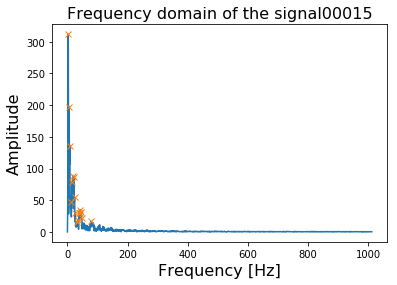

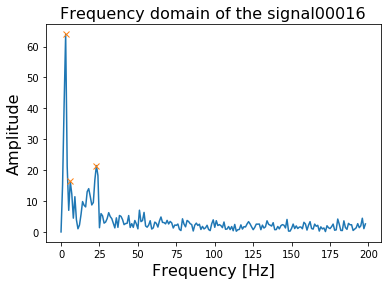

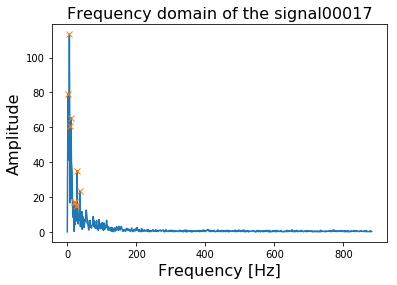

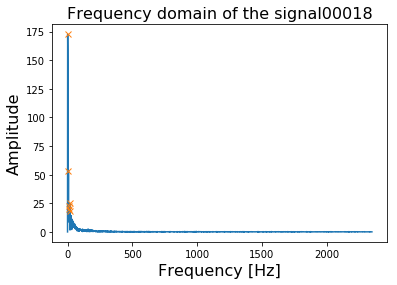

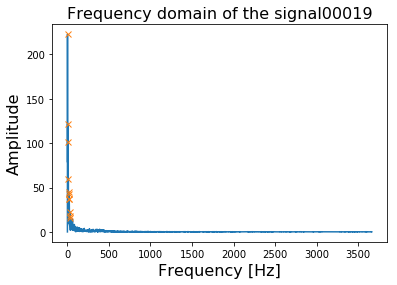

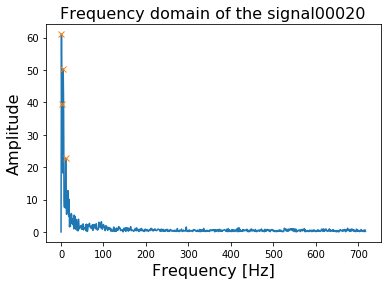

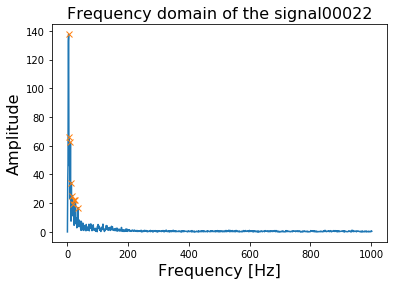

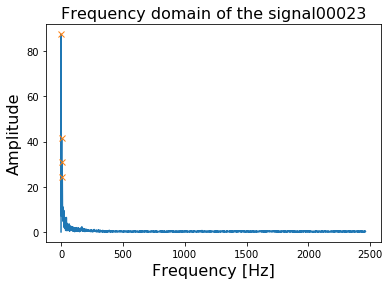

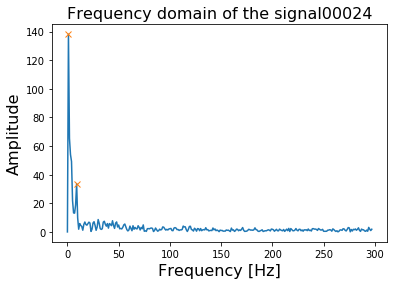

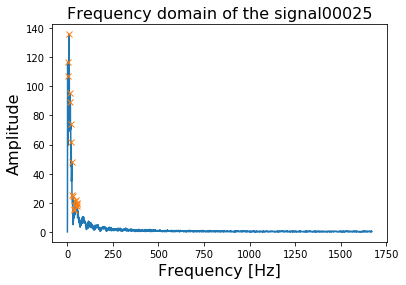

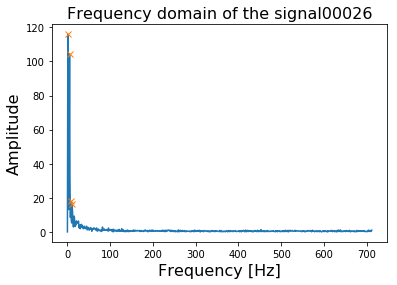

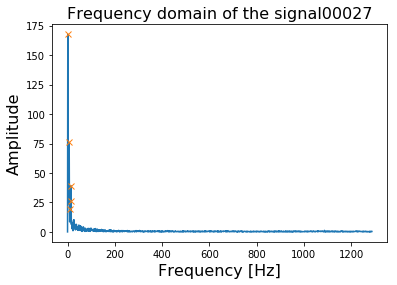

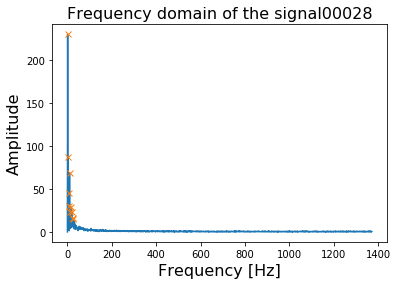

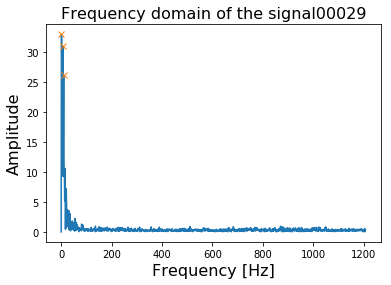

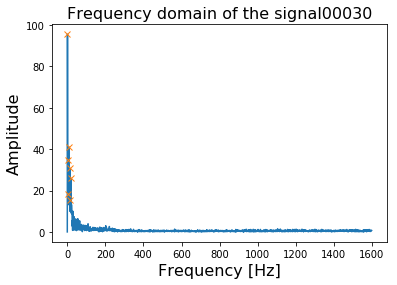

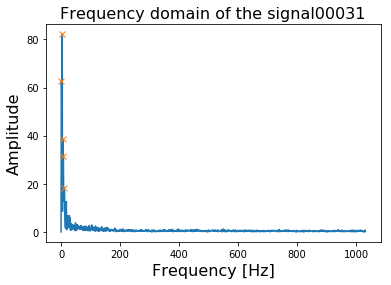

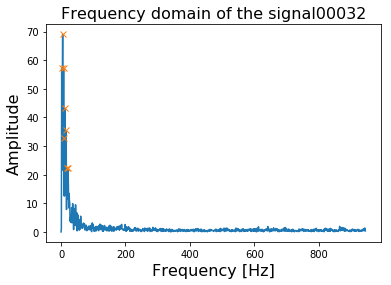

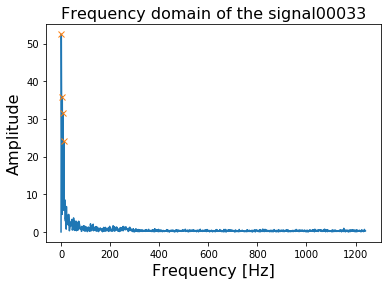

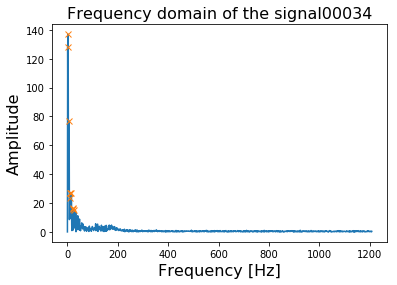

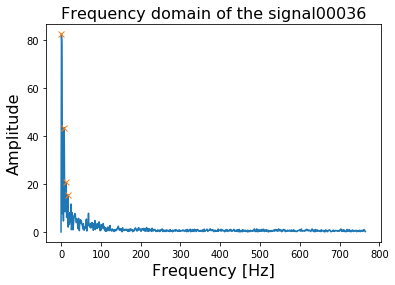

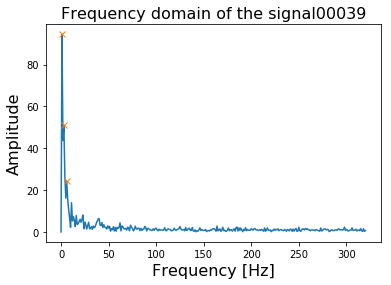

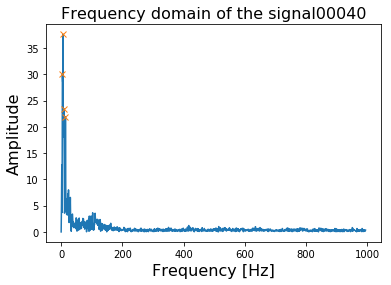

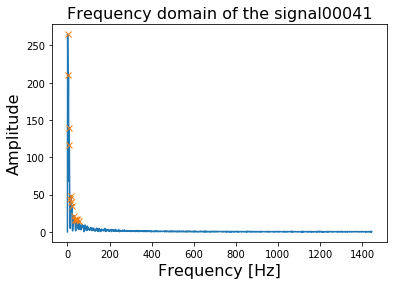

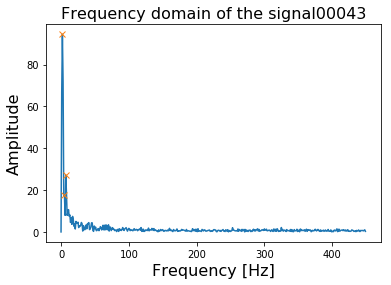

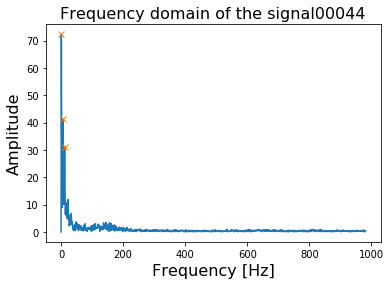

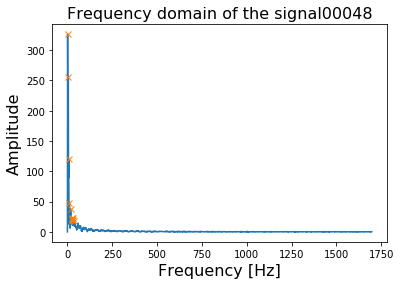

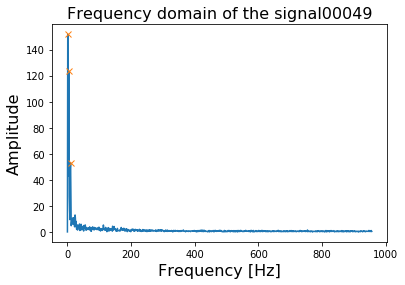

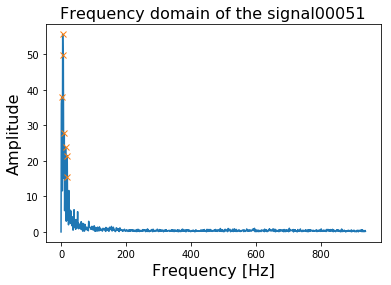

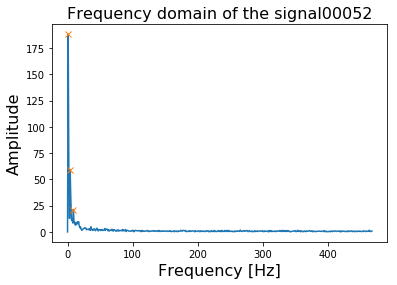

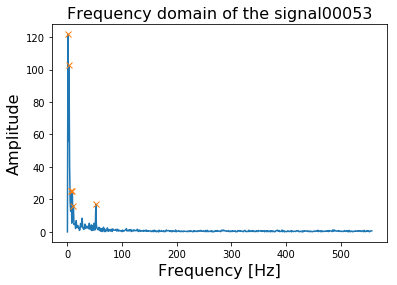

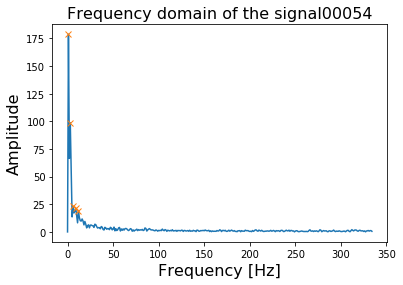

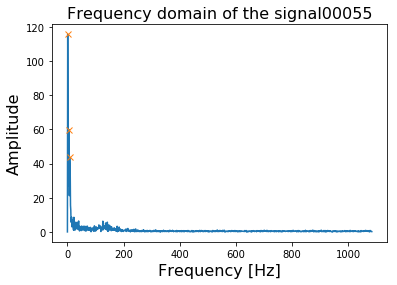

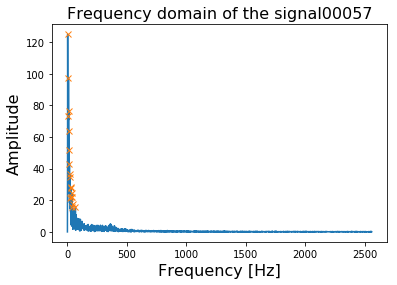

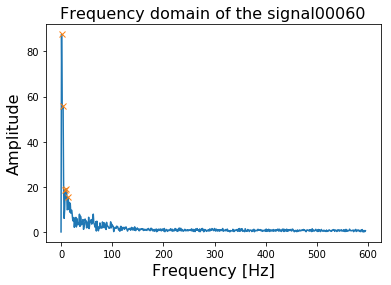

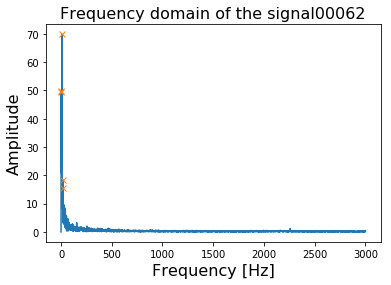

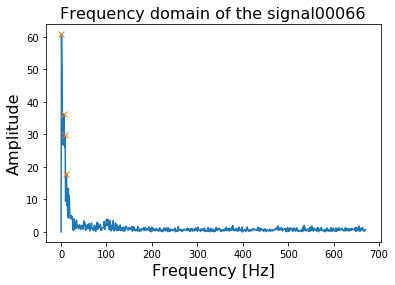

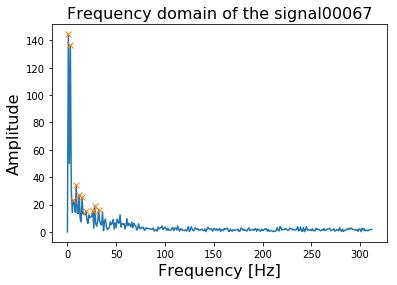

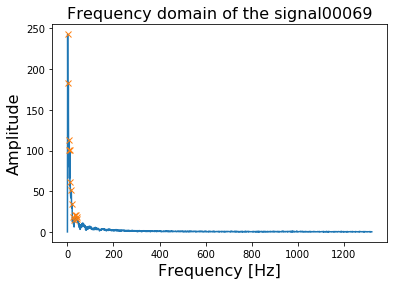

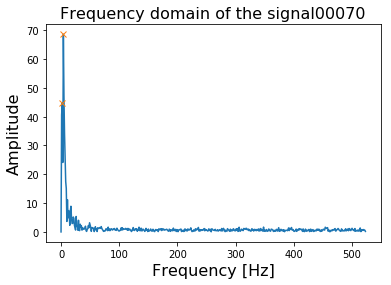

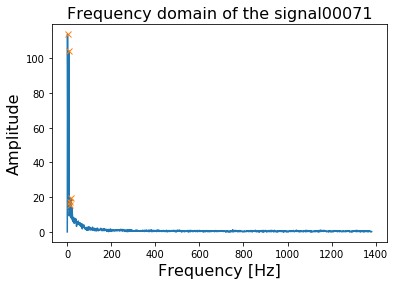

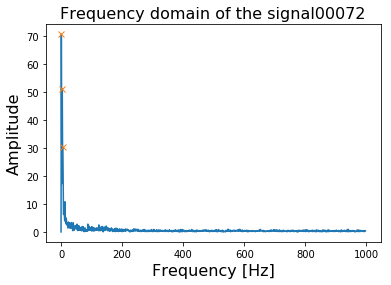

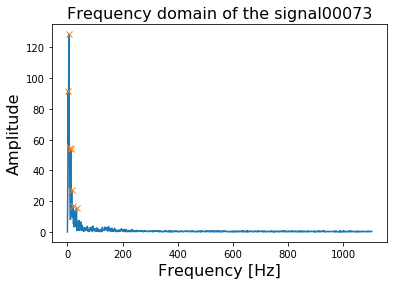

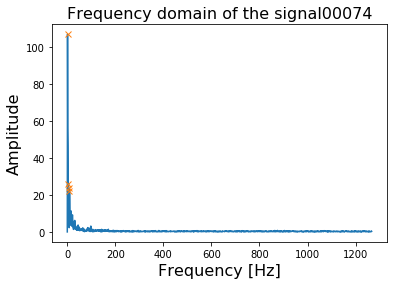

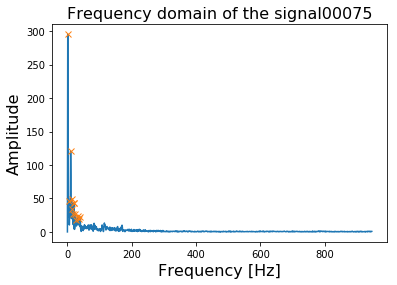

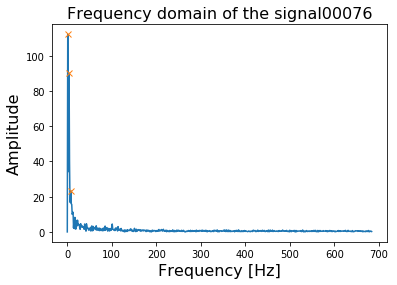

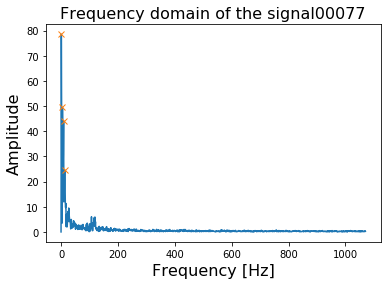

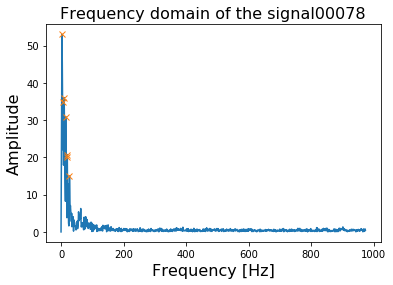

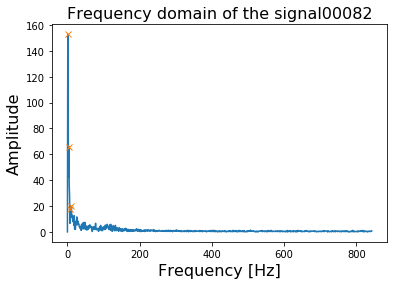

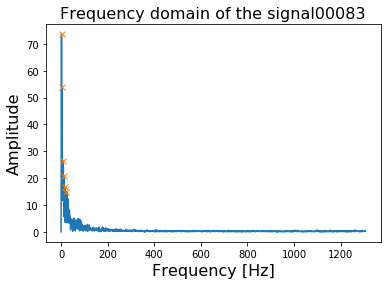

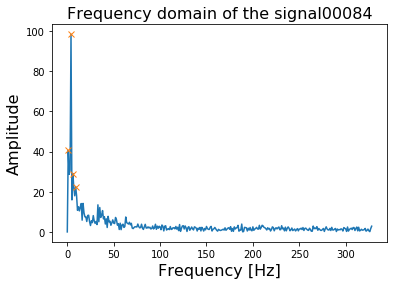

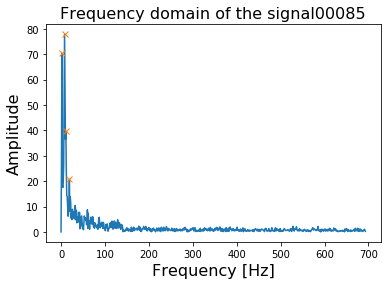

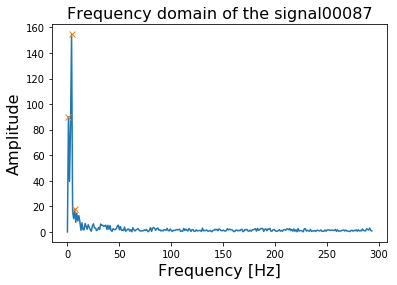

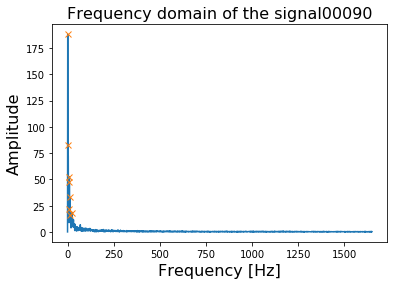

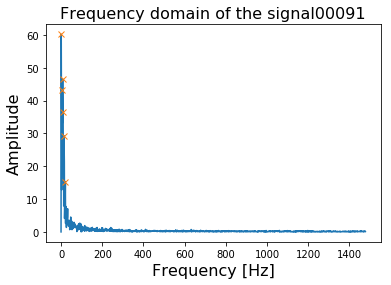

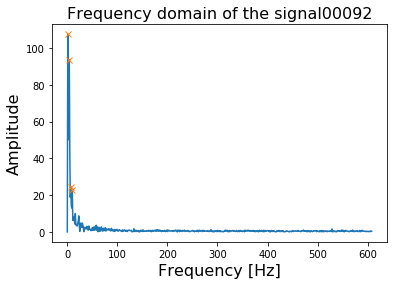

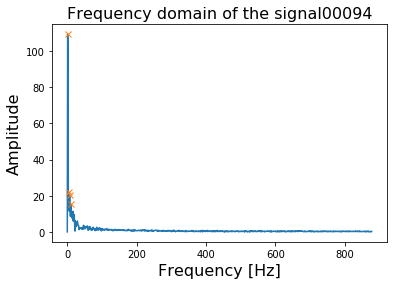

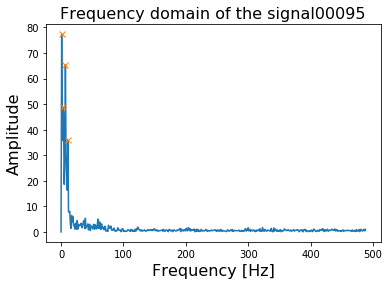

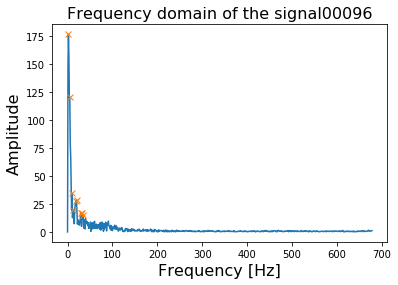

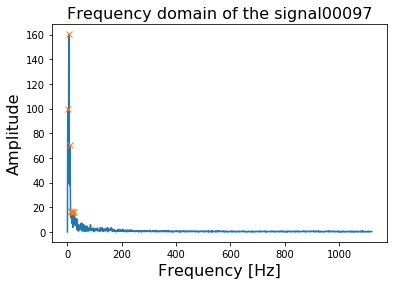

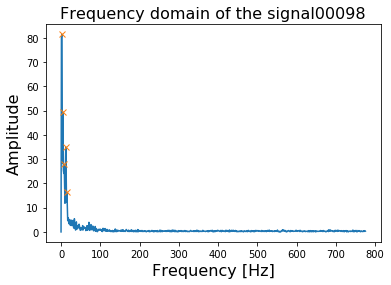

In [55]:
from detect_peaks import detect_peaks

signal_PaHaW = []

for i in charts:
    
    try: 

        df = pd.read_csv(i).reset_index()
        cols = ['Y coordinate', 'X coordinate', 'time stamp', 'on/off state', 'azimuth', 'altitude', 'pressure']
        df.columns = cols
        
        ids = os.path.dirname(i).split('\\')[-1]
        
        duration_org = df.iloc[-1, 2]-df.iloc[0, 2]
#         print(duration_org)
        
        pressure = df['pressure']
    
        pressure, first_index, last_index = preprocess(pressure) 
        
        duration = df.iloc[last_index, 2]-df.iloc[first_index, 2]
#         print(duration)
        
#         print(df['pressure'].shape)
#         print(pressure.shape)
        
        mean_pre = np.mean(pressure)
        pressure = pressure-mean_pre

        f_values, fft_values = get_fft_values(pressure, duration, len(pressure))
        
        peaks, _ = find_peaks(fft_values, height=5)
        ind = detect_peaks(x, mph=0, mpd=20, show=True)
#         peakind = signal.find_peaks_cwt(data, np.arange(1,10))
        
#         peaks, _ = find_peaks(fft_values, distance=150)
        plt.plot(fft_values)
        plt.xlabel('Frequency [Hz]', fontsize=16)
        plt.ylabel('Amplitude', fontsize=16)
        plt.title("Frequency domain of the signal" + ids, fontsize=16)
        plt.plot(peaks, fft_values[peaks], "x")
        plt.show()
        
#         fft_peaks = fft_values[peaks][0]+fft_values[peaks][1]+fft_values[peaks][2]+fft_values[peaks][3]+fft_values[peaks][4]
        

        
        signal_PaHaW.append([ids, fft_peaks])

    except:
        pass

# print(signal_PaHaW)

In [9]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [10]:
# Get the list of all files in directory tree at given path
files_HW = getListOfFiles('hw_dataset')

files_HW.remove('hw_dataset\\SVM_HW.ipynb')
files_HW.remove('hw_dataset\\readme.txt')
# files_HW

In [11]:
#only keep pressure data bwtween th first peak and the last peak
def preprocess_hw(x):

    peaks, _ = find_peaks(x, height=0)
    first_index = 0
    last_index = -1
    
    first_peak = x[peaks].iloc[0]
    last_peak = x[peaks].iloc[-1]
    for i in range(len(x)):
        if x[i] == first_peak:
            first_index = i
            break
            
    for j in reversed(range(len(x))):
        if x[j] == last_peak:
            last_index = j
            break

    x = x[first_index:last_index]
    
    return x, first_index, last_index

In [12]:
signal_HW = []

for i in files_HW:
    try:
        table = pd.read_csv(i, sep=';', index_col=False, header=None, names=['X coordinate', 'Y coordinate', 'Z', 'pressure', 'Grip Angle', 'time stamp', 'Test ID'],
                                  lineterminator='\n')
        table = table[table['Test ID'] == 1]
        table = table.drop('Z', axis=1)
        table = table[['X coordinate', 'Y coordinate', 'time stamp', 'pressure', 'Grip Angle', 'Test ID']]
#         duration_org = table.iloc[-1, 2]-table.iloc[0, 2]
#         print(duration_org)
        table.reset_index(inplace=True)

        pressure = table['pressure']

        pressure, first_index, last_index = preprocess_hw(pressure)
        
        duration = table.iloc[last_index, 2]-table.iloc[first_index, 2]
#         print(duration)
        

        mean_pre = np.mean(pressure)
        pressure = pressure-mean_pre

        f_values, fft_values = get_fft_values(pressure, duration, len(pressure))
        
        peaks, _ = find_peaks(fft_values, height=0)
        fft_peaks = fft_values[peaks][0]+fft_values[peaks][1]+fft_values[peaks][2]+fft_values[peaks][3]+fft_values[peaks][4]
        
#         f_values, psd_values = get_psd_values(pressure, duration, len(pressure))
#         peaks, _ = find_peaks(psd_values, height=0)
#         psd_peaks = psd_values[peaks][0]+psd_values[peaks][1]+psd_values[peaks][2]+psd_values[peaks][3]+psd_values[peaks][4]

        
        file_name = os.path.realpath(i).split('\\')[-1].split('.')[0]
        result = 0
        if file_name.split('_')[0] == 'P':
            result = 1
            ids = int(file_name.split('_')[1])
        if file_name.split('_')[0] == 'H':
            result = 1
            numb = file_name.split('_')[1]
            ids = int(numb.split('-')[1])
        if file_name.split('_')[0] == 'C':
            result = 0
            ids = int(file_name.split('_')[1])
        label = 2
        
        signal_HW.append([ids, fft_peaks, result])

#         plt.plot(f_values, fft_values, linestyle='-', color='blue')
#         plt.xlabel('Frequency [Hz]', fontsize=16)
#         plt.ylabel('Amplitude', fontsize=16)
#         plt.title("Frequency domain of the signal" + i, fontsize=16)
#         plt.show()
        
#         t_values, autocorr_values = get_autocorr_values(pressure, duration, len(pressure))
 
#         plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
#         plt.xlabel('time delay [s]')
#         plt.ylabel('Autocorrelation amplitude')
#         plt.show()
        
#     except Exception as e: print(e)
    except:
        pass

print(signal_HW)

[[1, 84.43568268131332, 0], [2, 136.87696911109643, 0], [3, 130.53598696858757, 0], [4, 156.38090359546348, 0], [5, 124.0322799269354, 0], [6, 121.46055269437424, 0], [7, 124.26972028969557, 0], [8, 128.7889052739653, 0], [9, 61.81707259733936, 0], [10, 116.08124404073577, 0], [11, 135.70850894199606, 0], [12, 208.24074678712705, 0], [13, 110.69485796350835, 0], [14, 145.95174162614404, 0], [15, 124.75778581508719, 0], [1, 171.56268125755196, 1], [2, 122.48299126213892, 1], [3, 151.79129629800278, 1], [4, 195.55785903002504, 1], [7, 156.22938644554836, 1], [8, 170.1837479099002, 1], [10, 107.35031102005522, 1], [11, 123.95994326736711, 1], [12, 156.57178499219813, 1], [13, 115.69030358319728, 1], [14, 197.4821700783302, 1], [15, 229.70020065767523, 1], [16, 307.6434129907805, 1], [20, 170.561144179445, 1], [23, 138.08861425964383, 1], [24, 157.2331967395569, 1], [25, 157.2331967395569, 1], [28, 115.03609038098706, 1], [29, 115.67294678040957, 1], [30, 67.06027034494605, 1], [31, 164.57

In [13]:
final = pd.DataFrame(signal_PaHaW)
final.columns = ['ID', 'fft']
final['ID'] = final['ID'].apply(lambda x: x.split('000')[1]).astype('int32')

df = pd.read_excel('PaHaW_csv/corpus_PaHaW.xlsx')
df['result'] = np.int32(df['PD status']=='ON')
final_data = pd.merge(final, df[['result', 'ID']], on='ID', how='left')

In [14]:
final_HW = pd.DataFrame(signal_HW)
final_HW.columns = ['ID','fft', 'result']
# final_data = final_data.append(final_HW)


In [15]:
ksstat, p_value= lilliefors(final_data['fft'])
if p_value < 0.1:
    print ("data are not normal distributed")
else:
    print (column, "data are normal distributed")

data are not normal distributed


In [16]:
ksstat, p_value= lilliefors(final_HW['fft'])
if p_value < 0.1:
    print ("data are not normal distributed")
else:
    print (column, "data are normal distributed")

data are not normal distributed


In [24]:
#null hypothesis that 2 independent samples are drawn from the same continuous distribution. 
#If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
from scipy.stats import ks_2samp

stats, p_value = ks_2samp(final_data['psd'], final_HW['psd'])
print(p_value>0.05)

## not comparable

False


In [38]:
X = np.array(final_HW[['fft']])
y = np.array(final_HW['result'])

In [46]:
##Decision Tree 10-FOLD
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

kf = KFold(n_splits=10, shuffle=True)

acc = []
pre = []
rec = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    acc.append(accuracy_score(y_test, pred))
    pre.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))

print(np.mean(acc))
print(np.mean(pre))
print(np.mean(rec))

0.6196428571428572
0.7697619047619048
0.748095238095238


In [44]:
##LR 10-FOLD
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=10, shuffle=True)

logisticRegr = LogisticRegression()
dt = tree.DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3)
clf = SVC(gamma='auto')

acc = []
pre = []
rec = []

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    
    acc.append(accuracy_score(y_test, pred))
    pre.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))

print(np.mean(acc))
print(np.mean(pre))
print(np.mean(rec))

0.7071428571428571
0.7776190476190475
0.9107142857142858


Parkinson_HW -- 64% 79.8% 74.8% (DT)
             -- 79.1% 79.4% 87.4% (LR)
PaHaW -- 44.7% 39.5% 39% (DT)
      -- 51% 28% 23% (LR)